In [1]:
import torch
import numpy as np
from scipy.linalg import sqrtm
import sklearn.datasets
import random
import pandas as pd
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

import os, sys
sys.path.append("..")

from distributions import StandardNormalSampler, DatasetSampler
from networks import PICNN
from embeddings import identity_encoder, one_hot_encoder
from copy import deepcopy
from training import pretrain_parabola, calculate_val_loss
from utils import split_data
from fairness_metrics import compute_KS

### Prepare the data

In [2]:
# import data
path = '../datasets/NLSY97.csv'
data = pd.read_csv(path, sep=',', index_col=False)

# drop pubID (R0000100) column
data = data.drop(columns=['R0000100'])

# create column named 'sensitive' with 0 if R1482600 is 4, 1 otherwise
data['sensitive'] = data['R1482600'].apply(lambda x: 0 if x == 4 else 1)

S_columns = ['sensitive']
# S_columns = ['R1482600']
Y_columns = ['R9871900']
# only first 10 by "importance"
X_columns = ["R9864300", "R0069300", "R9788800", "R9788900", "R0536401", "R1205400", "R1205300", "R9793100", "R0070400", "R0074300"]

# drop all rows where data[Y_columns[0]]<0
data = data[data[Y_columns[0]] >= 0]
# normalize Y column on [0,1]
data[Y_columns] = (data[Y_columns] - data[Y_columns].min()) / (data[Y_columns].max() - data[Y_columns].min())

# Normalize X columns
for col in X_columns:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### Split data

In [3]:
trial_n = 0

test_OT_size = 0.1
test_models_size = 0.3
ot_valid_size = 0.1

GPU_DEVICE = 0
device = torch.device(f'cuda:{GPU_DEVICE}' if torch.cuda.is_available() else 'cpu')

feature_dim = 32
feature_s_dim = 32
num_layers = 4

D_LR = 1e-3

BATCH_SIZE = np.Inf
MAX_ITER = 5_000
score_freq = 20

LAMBDA = 10
R_LAMBDA = 5

alpha_ridge = 1.0
gamma_RKLS = 0.1
n_estimators = 100

OUTPUT_FOLDER = './results/datasets/'
if OUTPUT_FOLDER is not None:
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

In [4]:
def pipeline(trial_n, NAME):

    random_state = trial_n
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    print("------------------------------------")
    print("Trial number: ", trial_n)

    X_train_OT, X_test_OT, X_valid_OT, S_train_OT, S_test_OT,S_valid_OT, Y_train_OT, Y_test_OT, X_train_unfair, X_test_unfair, S_train_unfair, S_test_unfair, Y_train_unfair, Y_test_unfair, X_train_fair, X_test_fair, S_train_fair, S_test_fair, Y_train_fair, Y_test_fair = split_data(data[X_columns], data[S_columns], data[Y_columns], test_OT_size=test_OT_size, test_models_size=test_models_size, ot_valid_size=ot_valid_size, random_state=random_state)

    # Create an instance of the sampler
    samplers = []
    for S_val in np.unique(S_train_OT): 
        index_val = (S_train_OT == S_val).squeeze()
        print("instances of s = ", S_val, ":", sum(index_val))
        samplers.append(DatasetSampler(X_train_OT.loc[index_val], S_train_OT.loc[index_val], device=device))

    DIM = samplers[0].X_dim
    NUM = len(samplers)

    encoder = one_hot_encoder(NUM)

    D = PICNN(input_x_dim=DIM,input_s_dim=NUM,feature_dim=feature_dim, feature_s_dim=feature_s_dim, out_dim= 1,num_layers=num_layers).to(device)
    print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

    D.initialize_weights('gaussian',device)
    pretrain_parabola(D, DIM, NUM, encoder, device)

    D_conj = deepcopy(D)

    D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
    D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=D_LR)

    # initialize validation samplers
    samplers_valid = []
    BATCH_SIZE = np.Inf
    for S_val in data[S_columns[0]].unique():
        index_val = (S_valid_OT == S_val).squeeze()
        if BATCH_SIZE > sum(index_val):
            BATCH_SIZE = sum(index_val)
        samplers_valid.append(DatasetSampler(X_valid_OT.loc[index_val], S_valid_OT.loc[index_val], device=device))

    alphas = [1/NUM]*NUM
    proposed_sampler =  StandardNormalSampler(dim=DIM, requires_grad=True, device=device)

    it = 0
    loss_history = []
    loss_validate_history = []
    full_log = {}

    iters = tqdm(range(MAX_ITER))
    for _ in iters:
        it += 1
        D.train(True); D.train(True); 
        loss = 0.

        for n in range(NUM):
            X,S = samplers[n].sample(BATCH_SIZE)
            X = X.to(device)
            S = S.to(device).flatten()
            X.requires_grad_(True)
            n_enc = encoder.encode(S)
            X_inv = D.push(X, n_enc).detach()
            loss += alphas[n] * ((X_inv * X).sum(dim=1).reshape(-1, 1) - D_conj(X_inv, n_enc)).mean()
        log = {'pure_loss' : loss.item()}
        
        # Cycle Loss
        cycle_loss = 0.
        
        for n in range(NUM):
            X,S = samplers[n].sample(BATCH_SIZE)
            X = X.to(device) 
            S = S.to(device).flatten()
            X.requires_grad_(True)
            # Cycle loss
            n_enc = encoder.encode(S)
            X_inv = D.push(X,n_enc)
            cycle_loss += alphas[n] * ((D_conj.push(X_inv,n_enc) - X.detach()) ** 2).mean()
        
        loss += LAMBDA * cycle_loss
        
        # Congruence Regularization Loss
        reg_loss = 0.

        Y = torch.cat(
            [proposed_sampler.sample(BATCH_SIZE).detach()] +
            [D.push(samplers[n].sample(BATCH_SIZE)[0].to(device).requires_grad_(True),
                    encoder.encode(samplers[n].sample(BATCH_SIZE)[1].flatten())
                    ).detach() for n in range(NUM)],
            dim=0
        ).detach()

        for n in range(NUM):
            reg_loss += alphas[n] * D_conj(Y, encoder.encode(n*torch.ones(len(Y),device=X.device))) 
        reg_loss -= ((Y ** 2).sum(dim=1) / 2).reshape(-1, 1)
        reg_loss = torch.relu(reg_loss).mean()
        
        loss += R_LAMBDA * reg_loss
        
        # # Positive constraint ! add this after change PICNN
        # loss += LAMBDA_REG_POS * (D.positive_constraint_loss()+D_conj.positive_constraint_loss())
        
        loss_history.append(loss.item())
        loss.backward()
        D_opt.step(); D_conj_opt.step()
        D_opt.zero_grad(); D_conj_opt.zero_grad(); 
        
        # for n in range(benchmark.num):
        #     D_conj.enforce_positive_weights()
        #     D.enforce_positive_weights()

        loss_validate_history.append(calculate_val_loss(D, D_conj, encoder, samplers_valid, 
                                                            proposed_sampler, alphas, LAMBDA, R_LAMBDA, 
                                                            BATCH_SIZE = 10, NUM= NUM, device=device).item())
        
        log = {
            **log,
            'full_loss' : loss.item(),
            'cycle_loss_XYX' : cycle_loss.item(),
            'reg_loss' : reg_loss.item(),
            'loss_validate' : loss_validate_history[-1],
        }        
        iters.set_postfix(loss = loss.item(), loss_validate = loss_validate_history[-1])
        if it % score_freq == 0:
            full_log[it] = log 

    plt.plot(loss_history, label='train', color='blue')
    plt.plot(loss_validate_history, label='validate', color='red')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Transport X_train_fair and X_test_fair
    X_train_fair_transp = D.push(
        torch.tensor(X_train_fair.to_numpy()).float().to(device).requires_grad_(True),
        encoder.encode(torch.tensor(S_train_fair.to_numpy()).float().to(device).flatten())
    ).detach().cpu().numpy()

    X_test_fair_transp = D.push(
        torch.tensor(X_test_fair.to_numpy()).float().to(device).requires_grad_(True),
        encoder.encode(torch.tensor(S_test_fair.to_numpy()).float().to(device).flatten())
    ).detach().cpu().numpy()

    # Ridge regression on unfair data
    ridge_unfair = Ridge(alpha=alpha_ridge)
    ridge_unfair.fit(X_train_fair, Y_train_fair)
    Y_pred_unfair = ridge_unfair.predict(X_test_fair)
    MSE_ridge_unfair = mean_squared_error(Y_test_fair, Y_pred_unfair)
    KS_ridge_unfair = compute_KS(Y_pred_unfair.squeeze(), S_test_fair)
    print("MSE on unfair data:", MSE_ridge_unfair)
    print("KS on unfair data:", KS_ridge_unfair)

    # Ridge regression on fair data
    ridge_fair = Ridge(alpha=alpha_ridge)
    ridge_fair.fit(X_train_fair_transp, Y_train_fair)
    Y_pred_fair = ridge_fair.predict(X_test_fair_transp)
    MSE_ridge_fair = mean_squared_error(Y_test_fair, Y_pred_fair)
    KS_ridge_fair = compute_KS(Y_pred_fair.squeeze(), S_test_fair)
    print("MSE on fair data:", MSE_ridge_fair)
    print("KS on fair data:", KS_ridge_fair)

    # Random forest on unfair data
    rf_unfair = RandomForestRegressor(n_estimators=n_estimators)
    rf_unfair.fit(X_train_fair, Y_train_fair.squeeze())
    Y_pred_unfair = rf_unfair.predict(X_test_fair)
    MSE_rf_unfair = mean_squared_error(Y_test_fair, Y_pred_unfair)
    KS_rf_unfair = compute_KS(Y_pred_unfair.squeeze(), S_test_fair)
    print("MSE on unfair data:", MSE_rf_unfair)
    print("KS on unfair data:", KS_rf_unfair)

    # Random forest on fair data
    rf_fair = RandomForestRegressor(n_estimators=n_estimators)
    rf_fair.fit(X_train_fair_transp, Y_train_fair.squeeze())
    Y_pred_fair = rf_fair.predict(X_test_fair_transp)
    MSE_rf_fair = mean_squared_error(Y_test_fair, Y_pred_fair)
    KS_rf_fair = compute_KS(Y_pred_fair.squeeze(), S_test_fair)
    print("MSE on fair data:", mean_squared_error(Y_test_fair, Y_pred_fair))
    print("KS on fair data:", compute_KS(Y_pred_fair.squeeze(), S_test_fair))

    # KRLS on unfair data
    KRLS_unfair = KernelRidge(kernel='rbf', gamma=gamma_RKLS)
    KRLS_unfair.fit(X_train_fair, Y_train_fair.squeeze())
    Y_pred_unfair = KRLS_unfair.predict(X_test_fair)
    MSE_KRLS_unfair = mean_squared_error(Y_test_fair, Y_pred_unfair)
    KS_KRLS_unfair = compute_KS(Y_pred_unfair.squeeze(), S_test_fair)
    print("MSE on unfair data:", MSE_KRLS_unfair)
    print("KS on unfair data:", KS_KRLS_unfair)

    # KRLS on fair data
    KRLS_fair = KernelRidge(kernel='rbf', gamma=gamma_RKLS)
    KRLS_fair.fit(X_train_fair_transp, Y_train_fair.squeeze())
    Y_pred_fair = KRLS_fair.predict(X_test_fair_transp)
    MSE_KRLS_fair = mean_squared_error(Y_test_fair, Y_pred_fair)
    KS_KRLS_fair = compute_KS(Y_pred_fair.squeeze(), S_test_fair)
    print("MSE on fair data:", mean_squared_error(Y_test_fair, Y_pred_fair))
    print("KS on fair data:", compute_KS(Y_pred_fair.squeeze(), S_test_fair))

    # save log 
    if OUTPUT_FOLDER is not None:
        pd.DataFrame.from_dict(full_log).T.to_csv(os.path.join(OUTPUT_FOLDER, NAME + '.csv'))

    return full_log, MSE_ridge_unfair, KS_ridge_unfair, MSE_ridge_fair, KS_ridge_fair, MSE_rf_unfair, KS_rf_unfair, MSE_rf_fair, KS_rf_fair, MSE_KRLS_unfair, KS_KRLS_unfair, MSE_KRLS_fair, KS_KRLS_fair

------------------------------------
Trial number:  0
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2687
instances of s =  1 : 2175
16529 parameters in Discriminative Network


 11%|█         | 2181/20000 [01:03<08:39, 34.30it/s, loss=0.00979]


Final Loss: 0.009791495278477669


100%|██████████| 5000/5000 [06:03<00:00, 13.75it/s, loss=1.26, loss_validate=1.24]  


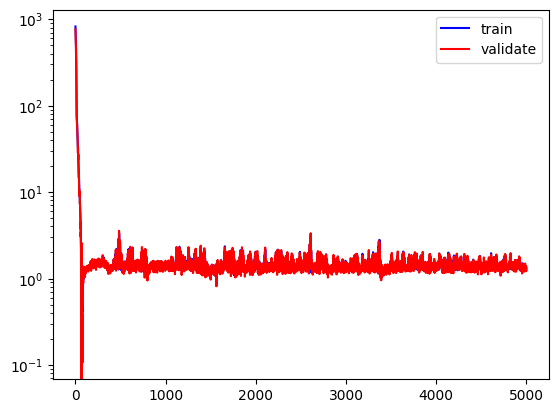

MSE on unfair data: 0.01799684918669017
KS on unfair data: 0.09583641290958364
MSE on fair data: 0.01810702597134968
KS on fair data: 0.131189948263119
MSE on unfair data: 0.018149988928530203
KS on unfair data: 0.1352549889135255
MSE on fair data: 0.01853950489200872
KS on fair data: 0.18760778516876078
MSE on unfair data: 0.017868485093089737
KS on unfair data: 0.09583641290958364
MSE on fair data: 0.01788670420373066
KS on fair data: 0.11924119241192412
------------------------------------
Trial number:  1
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2675
instances of s =  1 : 2187
16529 parameters in Discriminative Network


 12%|█▏        | 2308/20000 [01:08<08:42, 33.83it/s, loss=0.0094]


Final Loss: 0.009398390538990498


100%|██████████| 5000/5000 [06:05<00:00, 13.69it/s, loss=1.27, loss_validate=1.5]     


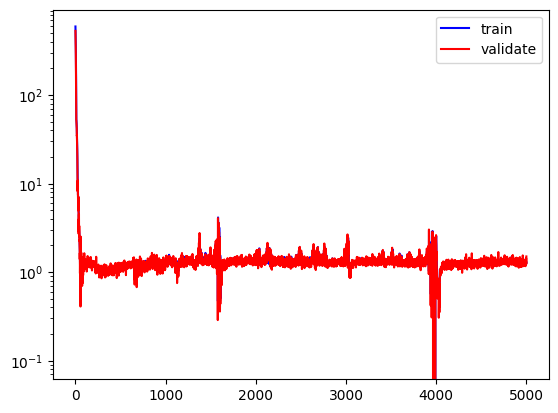

MSE on unfair data: 0.017534117050501535
KS on unfair data: 0.11401570937653412
MSE on fair data: 0.018144685182820454
KS on fair data: 0.11953853706431027
MSE on unfair data: 0.016916066378656138
KS on unfair data: 0.10677466863033873
MSE on fair data: 0.0171038191884731
KS on fair data: 0.13708885616102112
MSE on unfair data: 0.017947103433246535
KS on unfair data: 0.09977908689248896
MSE on fair data: 0.01765285478771342
KS on fair data: 0.1093519882179676
------------------------------------
Trial number:  2
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2664
instances of s =  1 : 2198
16529 parameters in Discriminative Network


 10%|▉         | 1983/20000 [00:57<08:45, 34.27it/s, loss=0.00981]


Final Loss: 0.00981101207435131


100%|██████████| 5000/5000 [06:06<00:00, 13.65it/s, loss=1.3, loss_validate=1.32]    


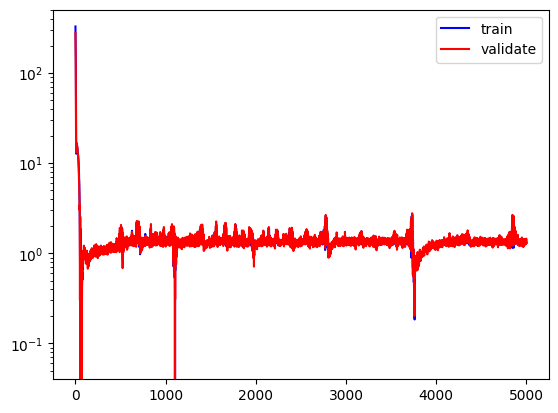

MSE on unfair data: 0.01736848456981916
KS on unfair data: 0.288249694002448
MSE on fair data: 0.01745132777497486
KS on fair data: 0.18910648714810283
MSE on unfair data: 0.016750828565852936
KS on unfair data: 0.33378212974296206
MSE on fair data: 0.017231523654706354
KS on fair data: 0.21505507955936354
MSE on unfair data: 0.017935431814910415
KS on unfair data: 0.2915544675642595
MSE on fair data: 0.017311692255700714
KS on fair data: 0.24504283965728274
------------------------------------
Trial number:  3
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2650
instances of s =  1 : 2212
16529 parameters in Discriminative Network


 11%|█         | 2190/20000 [01:01<08:21, 35.53it/s, loss=0.00996]


Final Loss: 0.009958988055586815


100%|██████████| 5000/5000 [06:03<00:00, 13.75it/s, loss=1.35, loss_validate=1.38]     


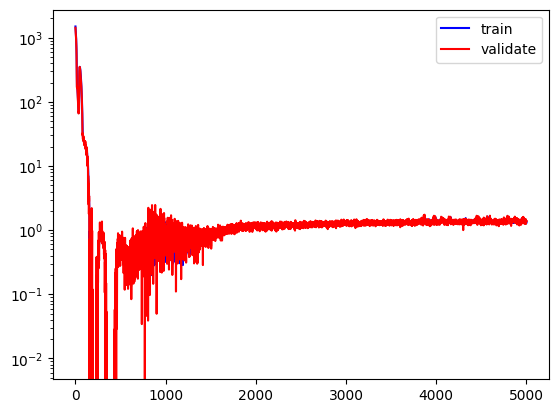

MSE on unfair data: 0.017017943603677976
KS on unfair data: 0.2342906234658812
MSE on fair data: 0.01758568091896515
KS on fair data: 0.15267550319096712
MSE on unfair data: 0.01750871866156187
KS on unfair data: 0.20115365733922436
MSE on fair data: 0.017441103369438986
KS on fair data: 0.3074374079528719
MSE on unfair data: 0.017006971027891914
KS on unfair data: 0.25589101620029453
MSE on fair data: 0.017065883279375544
KS on fair data: 0.22177221404025527
------------------------------------
Trial number:  4
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2683
instances of s =  1 : 2179
16529 parameters in Discriminative Network


 10%|█         | 2070/20000 [00:56<08:13, 36.35it/s, loss=0.00996]


Final Loss: 0.009955615736544132


100%|██████████| 5000/5000 [05:52<00:00, 14.20it/s, loss=1.39, loss_validate=1.45] 


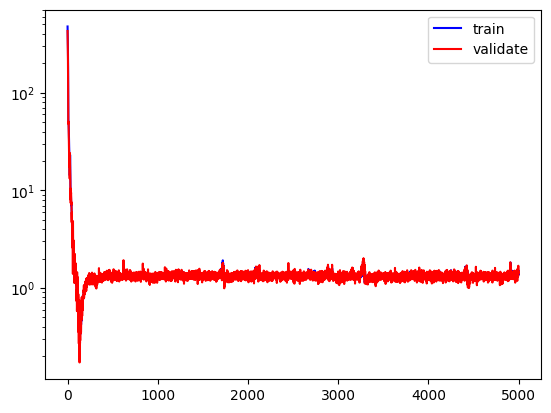

MSE on unfair data: 0.019344712643578565
KS on unfair data: 0.1487481590574374
MSE on fair data: 0.019722035180947974
KS on fair data: 0.11119293078055964
MSE on unfair data: 0.01796018423966352
KS on unfair data: 0.10198821796759941
MSE on fair data: 0.018777405253049707
KS on fair data: 0.21710849288168876
MSE on unfair data: 0.02014860807914708
KS on unfair data: 0.19734904270986744
MSE on fair data: 0.01945735696400998
KS on fair data: 0.0784241531664212
------------------------------------
Trial number:  5
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2682
instances of s =  1 : 2180
16529 parameters in Discriminative Network


 17%|█▋        | 3309/20000 [01:35<08:00, 34.73it/s, loss=0.00982]


Final Loss: 0.009823164902627468


100%|██████████| 5000/5000 [05:11<00:00, 16.07it/s, loss=1.34, loss_validate=1.31] 


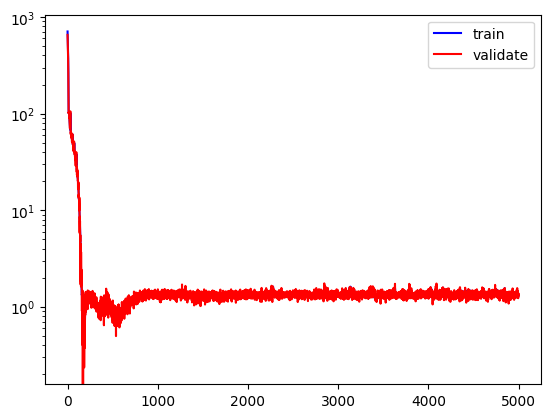

MSE on unfair data: 0.017459913057392803
KS on unfair data: 0.13886138613861387
MSE on fair data: 0.01808510455130383
KS on fair data: 0.1280940594059406
MSE on unfair data: 0.017238864701235916
KS on unfair data: 0.17425742574257425
MSE on fair data: 0.016780919970266615
KS on fair data: 0.22475247524752476
MSE on unfair data: 0.017226356874569377
KS on unfair data: 0.12784653465346535
MSE on fair data: 0.017203960474775574
KS on fair data: 0.11126237623762376
------------------------------------
Trial number:  6
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2690
instances of s =  1 : 2172
16529 parameters in Discriminative Network


 16%|█▌        | 3213/20000 [01:08<05:56, 47.14it/s, loss=0.0097]


Final Loss: 0.009702707640826702


100%|██████████| 5000/5000 [04:51<00:00, 17.14it/s, loss=1.31, loss_validate=1.32]     


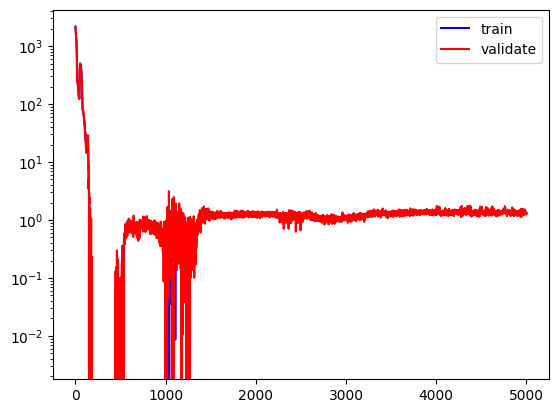

MSE on unfair data: 0.018705773239186988
KS on unfair data: 0.15635220125786164
MSE on fair data: 0.019140437195650065
KS on fair data: 0.08075471698113207
MSE on unfair data: 0.016035474863661154
KS on unfair data: 0.20855345911949685
MSE on fair data: 0.016735714967303052
KS on fair data: 0.16050314465408805
MSE on unfair data: 0.018758310736343497
KS on unfair data: 0.22138364779874214
MSE on fair data: 0.01910384654409877
KS on fair data: 0.14037735849056604
------------------------------------
Trial number:  7
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2689
instances of s =  1 : 2173
16529 parameters in Discriminative Network


 16%|█▋        | 3263/20000 [01:07<05:48, 48.07it/s, loss=0.00988]


Final Loss: 0.009876370429992676


100%|██████████| 5000/5000 [05:10<00:00, 16.08it/s, loss=1.28, loss_validate=1.46]   


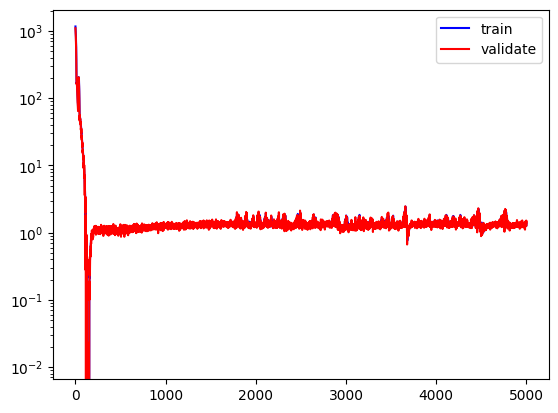

MSE on unfair data: 0.019618212103898563
KS on unfair data: 0.16570929070929072
MSE on fair data: 0.02068163424019354
KS on fair data: 0.15122377622377622
MSE on unfair data: 0.01795141404937888
KS on unfair data: 0.17495004995004995
MSE on fair data: 0.018588070741947568
KS on fair data: 0.17882117882117882
MSE on unfair data: 0.020690883658577616
KS on unfair data: 0.21428571428571427
MSE on fair data: 0.02014679408164505
KS on fair data: 0.08928571428571429
------------------------------------
Trial number:  8
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2684
instances of s =  1 : 2178
16529 parameters in Discriminative Network


 12%|█▏        | 2388/20000 [00:42<05:15, 55.84it/s, loss=0.00984]


Final Loss: 0.009835769422352314


100%|██████████| 5000/5000 [04:23<00:00, 19.00it/s, loss=1.47, loss_validate=1.59]  


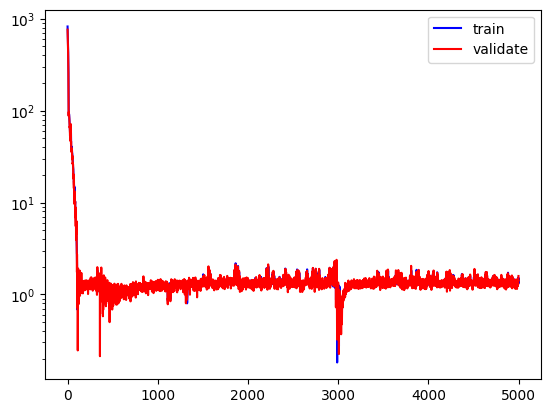

MSE on unfair data: 0.018908077768508978
KS on unfair data: 0.26309318908286206
MSE on fair data: 0.019242626401482915
KS on fair data: 0.12859601671994098
MSE on unfair data: 0.01734842501796633
KS on unfair data: 0.20985984755347922
MSE on fair data: 0.017477347482623928
KS on fair data: 0.2544873371035161
MSE on unfair data: 0.018741386187568806
KS on unfair data: 0.216744529136956
MSE on fair data: 0.017793563756112876
KS on fair data: 0.13929186132284238
------------------------------------
Trial number:  9
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2674
instances of s =  1 : 2188
16529 parameters in Discriminative Network


 15%|█▌        | 3074/20000 [00:56<05:11, 54.41it/s, loss=0.00928]


Final Loss: 0.009276834316551685


100%|██████████| 5000/5000 [04:19<00:00, 19.28it/s, loss=1.31, loss_validate=1.49]     


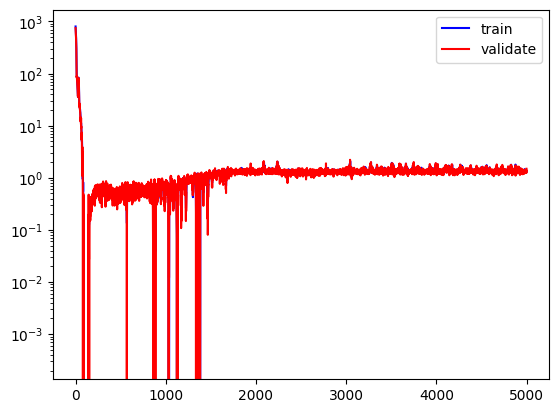

MSE on unfair data: 0.016944365171509105
KS on unfair data: 0.2756836659275684
MSE on fair data: 0.017028678711990573
KS on fair data: 0.12453806356245381
MSE on unfair data: 0.017319131653233757
KS on unfair data: 0.27087952697708795
MSE on fair data: 0.01716836358606758
KS on fair data: 0.22320768662232077
MSE on unfair data: 0.017182644644851093
KS on unfair data: 0.27297363882729736
MSE on fair data: 0.017199331367179316
KS on fair data: 0.18699186991869918
------------------------------------
Trial number:  10
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2651
instances of s =  1 : 2211
16529 parameters in Discriminative Network


 13%|█▎        | 2693/20000 [00:47<05:06, 56.39it/s, loss=0.00983]


Final Loss: 0.009827547706663609


100%|██████████| 5000/5000 [04:22<00:00, 19.02it/s, loss=1.34, loss_validate=1.16]  


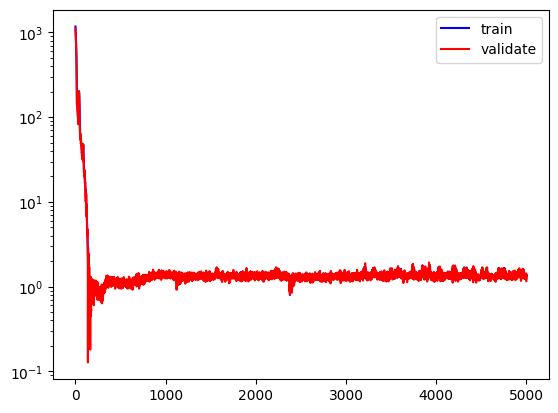

MSE on unfair data: 0.015042710751916422
KS on unfair data: 0.13380632312671148
MSE on fair data: 0.015208669284525009
KS on fair data: 0.11252178242469504
MSE on unfair data: 0.014923535203188221
KS on unfair data: 0.13542444610405777
MSE on fair data: 0.015165800678389758
KS on fair data: 0.13704256908140403
MSE on unfair data: 0.014482061503923381
KS on unfair data: 0.1633059497137167
MSE on fair data: 0.014375825793145674
KS on fair data: 0.08501369180980832
------------------------------------
Trial number:  11
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2679
instances of s =  1 : 2183
16529 parameters in Discriminative Network


 13%|█▎        | 2628/20000 [00:46<05:09, 56.15it/s, loss=0.00982]


Final Loss: 0.009824121370911598


100%|██████████| 5000/5000 [04:16<00:00, 19.52it/s, loss=1.28, loss_validate=1.29]   


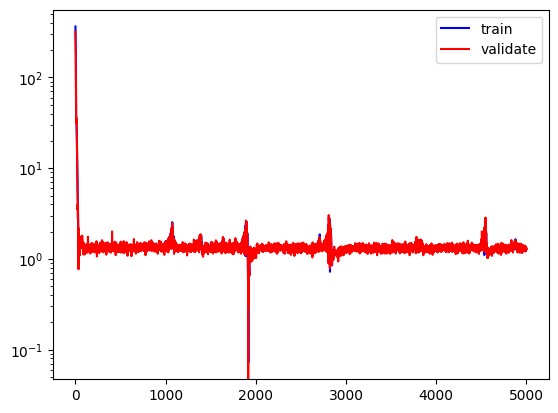

MSE on unfair data: 0.017988053119640263
KS on unfair data: 0.15505761843790014
MSE on fair data: 0.018255930977168284
KS on fair data: 0.10665813060179258
MSE on unfair data: 0.016731496091932932
KS on unfair data: 0.19026888604353392
MSE on fair data: 0.01622395941441647
KS on fair data: 0.20051216389244558
MSE on unfair data: 0.017831778897403377
KS on unfair data: 0.14839948783610754
MSE on fair data: 0.01783708476247423
KS on fair data: 0.09436619718309859
------------------------------------
Trial number:  12
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2692
instances of s =  1 : 2170
16529 parameters in Discriminative Network


 12%|█▏        | 2370/20000 [00:35<04:23, 66.82it/s, loss=0.00963]


Final Loss: 0.009628755040466785


100%|██████████| 5000/5000 [03:55<00:00, 21.22it/s, loss=0.752, loss_validate=0.856]


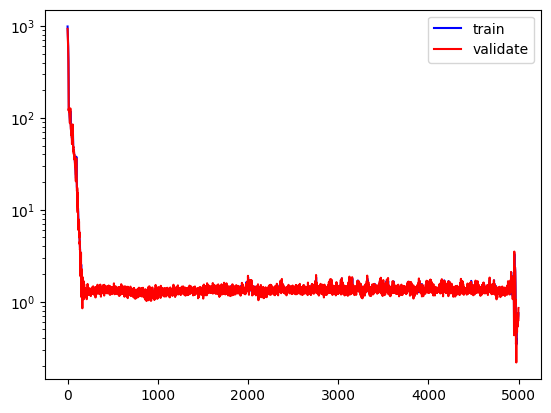

MSE on unfair data: 0.01378361788411652
KS on unfair data: 0.07484737484737485
MSE on fair data: 0.014344832555663623
KS on fair data: 0.07448107448107448
MSE on unfair data: 0.01362235837548936
KS on unfair data: 0.11465201465201465
MSE on fair data: 0.014797129052313871
KS on fair data: 0.17032967032967034
MSE on unfair data: 0.013690343635562787
KS on unfair data: 0.09133089133089133
MSE on fair data: 0.01347646174439437
KS on fair data: 0.08217338217338217
------------------------------------
Trial number:  13
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2685
instances of s =  1 : 2177
16529 parameters in Discriminative Network


 15%|█▍        | 2932/20000 [00:39<03:51, 73.88it/s, loss=0.00984]


Final Loss: 0.00983579084277153


100%|██████████| 5000/5000 [03:33<00:00, 23.39it/s, loss=1.38, loss_validate=1.42]   


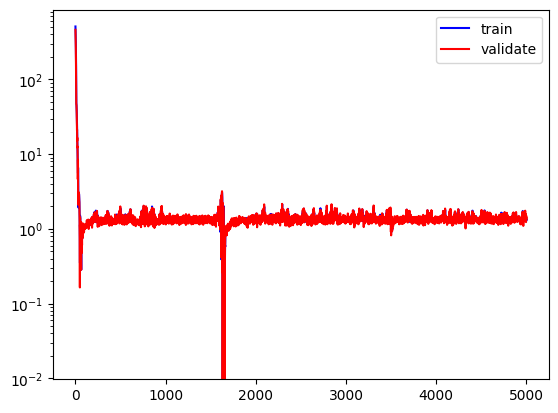

MSE on unfair data: 0.02101077085741557
KS on unfair data: 0.2590420332355816
MSE on fair data: 0.021890645718347278
KS on fair data: 0.21358748778103617
MSE on unfair data: 0.01945347635313155
KS on unfair data: 0.27908113391984357
MSE on fair data: 0.01977533451297823
KS on fair data: 0.2937438905180841
MSE on unfair data: 0.020598498543463805
KS on unfair data: 0.21480938416422288
MSE on fair data: 0.020926206523386753
KS on fair data: 0.15640273704789834
------------------------------------
Trial number:  14
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2690
instances of s =  1 : 2172
16529 parameters in Discriminative Network


 13%|█▎        | 2537/20000 [00:31<03:36, 80.65it/s, loss=0.00983]


Final Loss: 0.009828413836658001


100%|██████████| 5000/5000 [03:30<00:00, 23.78it/s, loss=1.32, loss_validate=1.32]   


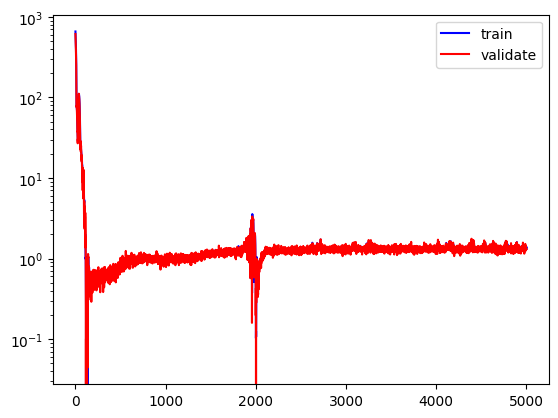

MSE on unfair data: 0.016069272938756513
KS on unfair data: 0.18700980392156863
MSE on fair data: 0.01667420686988
KS on fair data: 0.1025735294117647
MSE on unfair data: 0.015287864204912543
KS on unfair data: 0.2982843137254902
MSE on fair data: 0.014944504410227192
KS on fair data: 0.335906862745098
MSE on unfair data: 0.01610393876607806
KS on unfair data: 0.19705882352941176
MSE on fair data: 0.016204933028447333
KS on fair data: 0.12475490196078431
------------------------------------
Trial number:  15
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2689
instances of s =  1 : 2173
16529 parameters in Discriminative Network


 14%|█▍        | 2817/20000 [00:37<03:45, 76.10it/s, loss=0.00962]


Final Loss: 0.009616274386644363


100%|██████████| 5000/5000 [03:56<00:00, 21.16it/s, loss=1.31, loss_validate=1.53]   


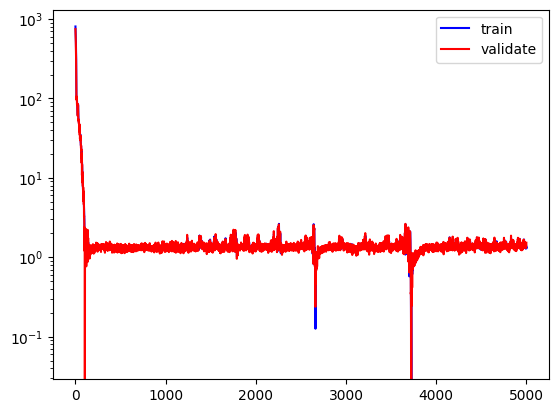

MSE on unfair data: 0.016084100782235614
KS on unfair data: 0.12537462537462538
MSE on fair data: 0.016709378870696373
KS on fair data: 0.11575924075924075
MSE on unfair data: 0.016002653780781036
KS on unfair data: 0.17532467532467533
MSE on fair data: 0.016557024780047305
KS on fair data: 0.14560439560439561
MSE on unfair data: 0.016247533848769855
KS on unfair data: 0.11775724275724275
MSE on fair data: 0.016391820224057482
KS on fair data: 0.12737262737262736
------------------------------------
Trial number:  16
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2676
instances of s =  1 : 2186
16529 parameters in Discriminative Network


 12%|█▏        | 2391/20000 [00:28<03:28, 84.35it/s, loss=0.00993]


Final Loss: 0.009928403422236443


100%|██████████| 5000/5000 [03:18<00:00, 25.22it/s, loss=1.36, loss_validate=1.44]  


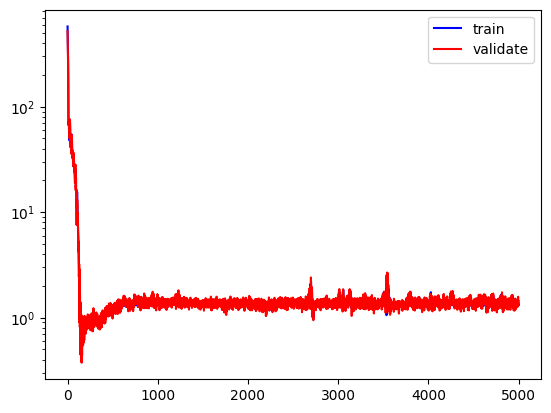

MSE on unfair data: 0.018903119039648943
KS on unfair data: 0.18230330106726234
MSE on fair data: 0.01917911189151855
KS on fair data: 0.0788036733680814
MSE on unfair data: 0.018915071047017507
KS on unfair data: 0.20352444775378506
MSE on fair data: 0.01846236971344821
KS on fair data: 0.17696698932737653
MSE on unfair data: 0.019138594714039493
KS on unfair data: 0.18391660461653014
MSE on fair data: 0.018804541865754282
KS on fair data: 0.10201042442293373
------------------------------------
Trial number:  17
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2663
instances of s =  1 : 2199
16529 parameters in Discriminative Network


 12%|█▏        | 2319/20000 [00:28<03:35, 82.09it/s, loss=0.00975]


Final Loss: 0.009754630737006664


100%|██████████| 5000/5000 [03:15<00:00, 25.54it/s, loss=1.47, loss_validate=1.29]  


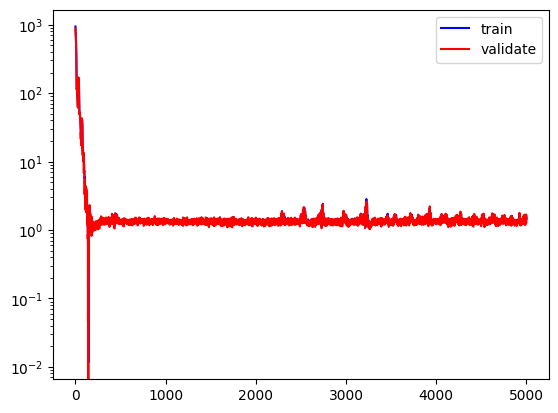

MSE on unfair data: 0.01901780641565326
KS on unfair data: 0.20066030814380045
MSE on fair data: 0.01973171039889164
KS on fair data: 0.09708975299584251
MSE on unfair data: 0.01914261213777959
KS on unfair data: 0.11127415015896307
MSE on fair data: 0.01859737535958097
KS on fair data: 0.07275617510393739
MSE on unfair data: 0.019360941105104352
KS on unfair data: 0.2210809488872585
MSE on fair data: 0.01940833391797784
KS on fair data: 0.09354365370506236
------------------------------------
Trial number:  18
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2704
instances of s =  1 : 2158
16529 parameters in Discriminative Network


 12%|█▏        | 2413/20000 [00:30<03:38, 80.40it/s, loss=0.0099]


Final Loss: 0.00989668071269989


100%|██████████| 5000/5000 [03:08<00:00, 26.52it/s, loss=1.04, loss_validate=1.05]     


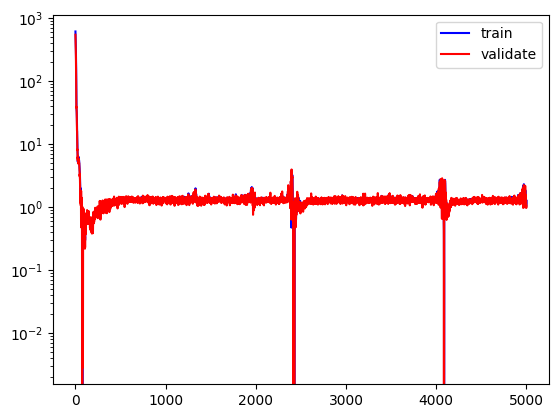

MSE on unfair data: 0.019310173532463285
KS on unfair data: 0.2047735618115055
MSE on fair data: 0.01996313456760057
KS on fair data: 0.17870257037943696
MSE on unfair data: 0.02126374548406937
KS on unfair data: 0.18372093023255814
MSE on fair data: 0.0201696962715112
KS on fair data: 0.42337821297429623
MSE on unfair data: 0.01930789693392699
KS on unfair data: 0.22252141982864138
MSE on fair data: 0.01892333273640178
KS on fair data: 0.19755201958384333
------------------------------------
Trial number:  19
length OT train: 4862
length OT test: 601
length unfair train: 420
length unfair test: 181
length fair train: 420
length fair test: 181
length OT valid: 541
instances of s =  0 : 2672
instances of s =  1 : 2190
16529 parameters in Discriminative Network


 16%|█▋        | 3260/20000 [00:36<03:06, 89.55it/s, loss=0.00999]


Final Loss: 0.00999385304749012


100%|██████████| 5000/5000 [03:09<00:00, 26.40it/s, loss=1.31, loss_validate=1.24]  


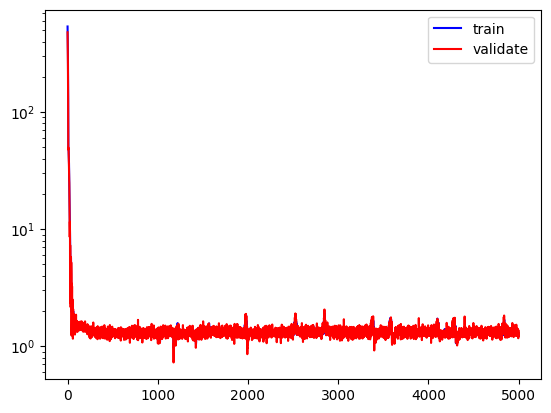

MSE on unfair data: 0.014243857224142798
KS on unfair data: 0.20636524374842133
MSE on fair data: 0.014860993474627259
KS on fair data: 0.14928012124273807
MSE on unfair data: 0.013995607920081565
KS on unfair data: 0.2727961606466279
MSE on fair data: 0.014612672311943358
KS on fair data: 0.2157110381409447
MSE on unfair data: 0.014397922633680922
KS on unfair data: 0.25208385956049506
MSE on fair data: 0.014045695292091487
KS on fair data: 0.1981561000252589


In [5]:
tot_trails = 20

list_logs = []
list_MSE_ridge_unfair = []
list_KS_ridge_unfair = []
list_MSE_ridge_fair = []
list_KS_ridge_fair = []
list_MSE_rf_unfair = []
list_KS_rf_unfair = []
list_MSE_rf_fair = []
list_KS_rf_fair = []
list_MSE_KRLS_unfair = []
list_KS_KRLS_unfair = []
list_MSE_KRLS_fair = []
list_KS_KRLS_fair = []

for trial_n in range(tot_trails):
    NAME = 'NLSY97_trial_' + str(trial_n)
    log, MSE_ridge_unfair, KS_ridge_unfair, MSE_ridge_fair, KS_ridge_fair, MSE_rf_unfair, KS_rf_unfair, MSE_rf_fair, KS_rf_fair, MSE_KRLS_unfair, KS_KRLS_unfair, MSE_KRLS_fair, KS_KRLS_fair = pipeline(trial_n, NAME)
    list_logs.append(log)
    list_MSE_ridge_unfair.append(MSE_ridge_unfair)
    list_KS_ridge_unfair.append(KS_ridge_unfair)
    list_MSE_ridge_fair.append(MSE_ridge_fair)
    list_KS_ridge_fair.append(KS_ridge_fair)
    list_MSE_rf_unfair.append(MSE_rf_unfair)
    list_KS_rf_unfair.append(KS_rf_unfair)
    list_MSE_rf_fair.append(MSE_rf_fair)
    list_KS_rf_fair.append(KS_rf_fair)
    list_MSE_KRLS_unfair.append(MSE_KRLS_unfair)
    list_KS_KRLS_unfair.append(KS_KRLS_unfair)
    list_MSE_KRLS_fair.append(MSE_KRLS_fair)
    list_KS_KRLS_fair.append(KS_KRLS_fair)

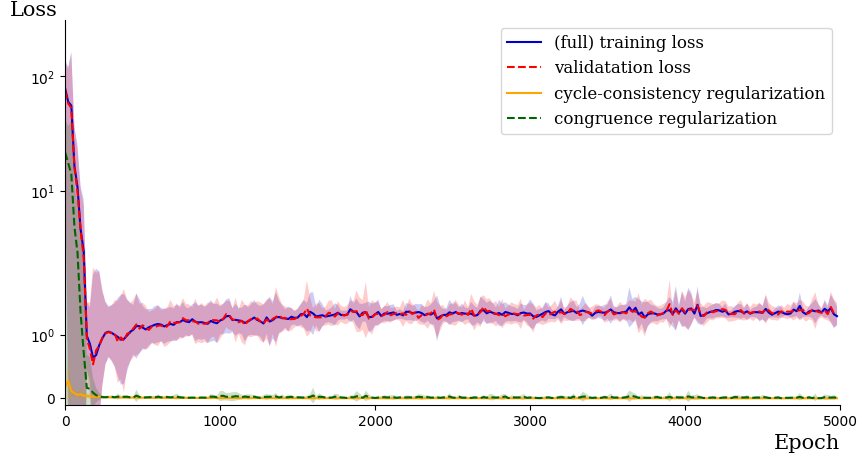

In [15]:
# PLOT LOSSES from log
mean_full_loss = 0.
mean_cycle_loss = 0.
mean_reg_loss = 0.
mean_loss_validate = 0.

for log in list_logs:
    mean_full_loss += np.array([log[i]['full_loss'] for i in log])/tot_trails
    mean_cycle_loss += np.array([log[i]['cycle_loss_XYX'] for i in log])/tot_trails
    mean_reg_loss += np.array([log[i]['reg_loss'] for i in log])/tot_trails
    mean_loss_validate += np.array([log[i]['loss_validate'] for i in log])/tot_trails

std_full_loss = np.std([np.array([log[i]['full_loss'] for i in log]) for log in list_logs], axis=0)
std_cycle_loss = np.std([np.array([log[i]['cycle_loss_XYX'] for i in log]) for log in list_logs], axis=0)
std_reg_loss = np.std([np.array([log[i]['reg_loss'] for i in log]) for log in list_logs], axis=0)
std_loss_validate = np.std([np.array([log[i]['loss_validate'] for i in log]) for log in list_logs], axis=0)

# plot mean and faded stds
plt.figure(figsize=(10, 5))
plt.plot(mean_full_loss, label='(full) training loss', color='mediumblue')
plt.fill_between(range(len(mean_full_loss)), mean_full_loss - std_full_loss, mean_full_loss + std_full_loss, alpha=0.2, color='mediumblue', edgecolor=None)
plt.plot(mean_loss_validate, label='validatation loss', color='red', linestyle='--')
plt.fill_between(range(len(mean_full_loss)), mean_loss_validate - std_loss_validate, mean_loss_validate + std_loss_validate, alpha=0.2, color='red', edgecolor=None)
plt.plot(mean_cycle_loss, label='cycle-consistency regularization', color='orange')
plt.fill_between(range(len(mean_full_loss)), mean_cycle_loss - std_cycle_loss, mean_cycle_loss + std_cycle_loss, alpha=0.2, color='orange', edgecolor=None)
plt.plot(mean_reg_loss, label='congruence regularization', color='darkgreen',linestyle='--')
plt.fill_between(range(len(mean_full_loss)), mean_reg_loss - std_reg_loss, mean_reg_loss + std_reg_loss, alpha=0.2, color='darkgreen', edgecolor=None)
plt.yscale('symlog', linthresh=2e-0)
plt.ylim(bottom=-0.1)
plt.ylabel('Loss',fontdict={'fontfamily': 'serif', 'weight': 10, 'size': 15}, loc='top', rotation=0, labelpad=-20) # lower the label a bit
plt.xlabel('Epoch',fontdict={'fontfamily': 'serif', 'weight': 10, 'size': 15}, loc='right', ) # lower the label a bit
# multiply x axis ticks by score_freq
ticks = plt.xticks()[0]
plt.xticks(ticks[1:], [int(tick*score_freq) for tick in ticks[1:]])
plt.xlim(left=0, right=len(mean_full_loss))
plt.legend(prop={'family': 'serif', 'weight': 10, 'size': 12})
# get rid of border on top and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(OUTPUT_FOLDER + 'NLSY_losses.png')

In [16]:
# Mean and std of MSE and KS
mean_MSE_ridge_unfair = np.mean(list_MSE_ridge_unfair)
std_MSE_ridge_unfair = np.std(list_MSE_ridge_unfair)
mean_KS_ridge_unfair = np.mean(list_KS_ridge_unfair)
std_KS_ridge_unfair = np.std(list_KS_ridge_unfair)

mean_MSE_ridge_fair = np.mean(list_MSE_ridge_fair)
std_MSE_ridge_fair = np.std(list_MSE_ridge_fair)
mean_KS_ridge_fair = np.mean(list_KS_ridge_fair)
std_KS_ridge_fair = np.std(list_KS_ridge_fair)

mean_MSE_rf_unfair = np.mean(list_MSE_rf_unfair)
std_MSE_rf_unfair = np.std(list_MSE_rf_unfair)
mean_KS_rf_unfair = np.mean(list_KS_rf_unfair)
std_KS_rf_unfair = np.std(list_KS_rf_unfair)

mean_MSE_rf_fair = np.mean(list_MSE_rf_fair)
std_MSE_rf_fair = np.std(list_MSE_rf_fair)
mean_KS_rf_fair = np.mean(list_KS_rf_fair)
std_KS_rf_fair = np.std(list_KS_rf_fair)

mean_MSE_KRLS_unfair = np.mean(list_MSE_KRLS_unfair)
std_MSE_KRLS_unfair = np.std(list_MSE_KRLS_unfair)
mean_KS_KRLS_unfair = np.mean(list_KS_KRLS_unfair)
std_KS_KRLS_unfair = np.std(list_KS_KRLS_unfair)

mean_MSE_KRLS_fair = np.mean(list_MSE_KRLS_fair)
std_MSE_KRLS_fair = np.std(list_MSE_KRLS_fair)
mean_KS_KRLS_fair = np.mean(list_KS_KRLS_fair)
std_KS_KRLS_fair = np.std(list_KS_KRLS_fair)

print("Ridge regression on unfair data:")
print(f'MSE: {mean_MSE_ridge_unfair} +- {std_MSE_ridge_unfair}')
print(f'KS: {mean_KS_ridge_unfair} +- {std_KS_ridge_unfair}')

print("Ridge regression on fair data:")
print(f'MSE: {mean_MSE_ridge_fair} +- {std_MSE_ridge_fair}')
print(f'KS: {mean_KS_ridge_fair} +- {std_KS_ridge_fair}')

print("Random forest on unfair data:")
print(f'MSE: {mean_MSE_rf_unfair} +- {std_MSE_rf_unfair}')
print(f'KS: {mean_KS_rf_unfair} +- {std_KS_rf_unfair}')

print("Random forest on fair data:")
print(f'MSE: {mean_MSE_rf_fair} +- {std_MSE_rf_fair}')
print(f'KS: {mean_KS_rf_fair} +- {std_KS_rf_fair}')

print("KRLS on unfair data:")
print(f'MSE: {mean_MSE_KRLS_unfair} +- {std_MSE_KRLS_unfair}')
print(f'KS: {mean_KS_KRLS_unfair} +- {std_KS_KRLS_unfair}')

print("KRLS on fair data:")
print(f'MSE: {mean_MSE_KRLS_fair} +- {std_MSE_KRLS_fair}')
print(f'KS: {mean_KS_KRLS_fair} +- {std_KS_KRLS_fair}')

# save in a csv file
if OUTPUT_FOLDER is not None:
    with open(os.path.join(OUTPUT_FOLDER, 'NLSY_metrics_results.csv'), 'w') as f:
        f.write('MSE_ridge_unfair, std_MSE_ridge_unfair, mean_KS_ridge_unfair, std_KS_ridge_unfair, MSE_ridge_fair, std_MSE_ridge_fair, mean_KS_ridge_fair, std_KS_ridge_fair, MSE_rf_unfair, std_MSE_rf_unfair, mean_KS_rf_unfair, std_KS_rf_unfair, MSE_rf_fair, std_MSE_rf_fair, mean_KS_rf_fair, std_KS_rf_fair, MSE_KRLS_unfair, std_MSE_KRLS_unfair, mean_KS_KRLS_unfair, std_KS_KRLS_unfair, MSE_KRLS_fair, std_MSE_KRLS_fair, mean_KS_KRLS_fair, std_KS_KRLS_fair\n')
        f.write(f'{mean_MSE_ridge_unfair}, {std_MSE_ridge_unfair}, {mean_KS_ridge_unfair}, {std_KS_ridge_unfair}, {mean_MSE_ridge_fair}, {std_MSE_ridge_fair}, {mean_KS_ridge_fair}, {std_KS_ridge_fair}, {mean_MSE_rf_unfair}, {std_MSE_rf_unfair}, {mean_KS_rf_unfair}, {std_KS_rf_unfair}, {mean_MSE_rf_fair}, {std_MSE_rf_fair}, {mean_KS_rf_fair}, {std_KS_rf_fair}, {mean_MSE_KRLS_unfair}, {std_MSE_KRLS_unfair}, {mean_KS_KRLS_unfair}, {std_KS_KRLS_unfair}, {mean_MSE_KRLS_fair}, {std_MSE_KRLS_fair}, {mean_KS_KRLS_fair}, {std_KS_KRLS_fair}\n')

Ridge regression on unfair data:
MSE: 0.01761759654703765 +- 0.0018231115353000526
KS: 0.18050402628214163 +- 0.059340098043899336
Ridge regression on fair data:
MSE: 0.018100392536929886 +- 0.0018990751112564891
KS: 0.12731837013930025 +- 0.035750420951260485
Random forest on unfair data:
MSE: 0.017125875882906223 +- 0.0018107092187919665
KS: 0.1940902565248944 +- 0.06621729689299898
Random forest on fair data:
MSE: 0.017257481980537108 +- 0.0015610518236888614
KS: 0.21390107059449934 +- 0.07757748008608771
KRLS on unfair data:
MSE: 0.017733284606607454 +- 0.001950206449000564
KS: 0.19029543516015937 +- 0.05862152675364315
KRLS on fair data:
MSE: 0.017560811180123658 +- 0.0019236025985908403
KS: 0.1351193651516997 +- 0.048692556080249944


# Benchmark CHZHEN

In [8]:
from sklearn.model_selection import train_test_split

def pred_chzhen(model,sigma = 0.001,random_state = 0):
    Us = [X_train_fair.loc[(S_train_fair == S_val).squeeze()] for S_val in np.unique(S_train_fair)]
    ps = [sum((S_train_fair == S_val).squeeze())/len(S_train_fair) for S_val in np.unique(S_train_fair)]
    S_vals = np.unique(S_train_fair)

    ar_as = {}
    ar_bs = {}
    ps_dict = {}

    for _ in range(len(Us)):
        # split Us[_] into two parts:
        U_a, U_b = train_test_split(Us[_], test_size=0.5, random_state=random_state)
        ar_a = model.predict(np.concatenate([U_a.to_numpy(), np.ones((len(U_a),1))*S_vals[_]], axis=1))
        ar_a.sort()
        ar_b = model.predict(np.concatenate([U_b.to_numpy(), np.ones((len(U_b),1))*S_vals[_]], axis=1))
        ar_b.sort()
        ar_as[S_vals[_]] = ar_a 
        ar_bs[S_vals[_]] = ar_b     
        ps_dict[S_vals[_]] = ps[_] 

    preds = model.predict(pd.concat([X_test_fair,S_test_fair], axis=1))
    list_b = [ar_bs[s] for s in S_test_fair.values.squeeze()]
    ks = []
    for _ in range(len(list_b)):
        ks.append(np.searchsorted(list_b[_], preds[_]+np.random.uniform(-sigma, sigma)))
    indices = np.floor(np.array([ps_dict[s] for s in S_test_fair.values.squeeze()])*np.array(ks)).astype(int)
    _ = 0
    fair_preds = 0.
    for ar_a in ar_as.values():
        fair_preds += ar_a[indices]*ps[_]
        _+=1

    return fair_preds

In [9]:
import warnings
warnings.filterwarnings("ignore")

KSs = []
MSES = []

for trial_n in range(tot_trails):
    random_state = trial_n

    # random forrest to predict Y from X and S
    X_train_OT, X_test_OT, X_valid_OT, S_train_OT, S_test_OT,S_valid_OT, Y_train_OT, Y_test_OT, X_train_unfair, X_test_unfair, S_train_unfair, S_test_unfair, Y_train_unfair, Y_test_unfair, X_train_fair, X_test_fair, S_train_fair, S_test_fair, Y_train_fair, Y_test_fair = split_data(data[X_columns], data[S_columns], data[Y_columns], test_OT_size=test_OT_size, test_models_size=test_models_size, ot_valid_size=ot_valid_size, random_state=random_state, verbose=False)
    # X_train_fair,S_train_fair,Y_train_fair = data[X_columns], data[S_columns], data[Y_columns]
    rf = RandomForestRegressor(n_estimators=50)
    rf.fit(pd.concat([X_train_fair,S_train_fair], axis=1), Y_train_fair.squeeze())
    Y_pred = rf.predict(pd.concat([X_test_fair,S_test_fair], axis=1))
    MSE_rf = mean_squared_error(Y_test_fair, Y_pred)
    KS_rf = compute_KS(Y_pred.squeeze(), S_test_fair)
    # print("MSE on fair data:", MSE_rf)
    # print("KS on fair data:", KS_rf)

    fair_preds = pred_chzhen(rf, sigma = 0.001, random_state = random_state)

    # MSE and KS of fair_preds
    MSE_fair_preds = mean_squared_error(Y_test_fair, fair_preds)
    KS_fair_preds = compute_KS(fair_preds.squeeze(), S_test_fair)
    # print("MSE on fair data:", MSE_fair_preds)
    KSs.append(KS_fair_preds)
    MSES.append(MSE_fair_preds)


In [10]:
print("MSE on fair rf:", np.mean(MSES), "+-", np.std(MSES))
print("KS on fair rf:", np.mean(KSs), "+-", np.std(KSs))

MSE on fair rf: 0.025107884641288304 +- 0.003338617460299657
KS on fair rf: 0.3750824114757755 +- 0.13361686158532501


In [11]:
# ridge

KSs = []
MSES = []

for trial_n in range(tot_trails):
    random_state = trial_n

    # random forrest to predict Y from X and S
    X_train_OT, X_test_OT, X_valid_OT, S_train_OT, S_test_OT,S_valid_OT, Y_train_OT, Y_test_OT, X_train_unfair, X_test_unfair, S_train_unfair, S_test_unfair, Y_train_unfair, Y_test_unfair, X_train_fair, X_test_fair, S_train_fair, S_test_fair, Y_train_fair, Y_test_fair = split_data(data[X_columns], data[S_columns], data[Y_columns], test_OT_size=test_OT_size, test_models_size=test_models_size, ot_valid_size=ot_valid_size, random_state=random_state, verbose=False)
    # X_train_fair,S_train_fair,Y_train_fair = data[X_columns], data[S_columns], data[Y_columns]
    rf = Ridge(alpha=alpha_ridge)
    rf.fit(pd.concat([X_train_fair,S_train_fair], axis=1), Y_train_fair.squeeze())
    Y_pred = rf.predict(pd.concat([X_test_fair,S_test_fair], axis=1))
    MSE_rf = mean_squared_error(Y_test_fair, Y_pred)
    KS_rf = compute_KS(Y_pred.squeeze(), S_test_fair)
    # print("MSE on fair data:", MSE_rf)
    # print("KS on fair data:", KS_rf)

    fair_preds = pred_chzhen(rf, sigma = 0.001, random_state = random_state)

    # MSE and KS of fair_preds
    MSE_fair_preds = mean_squared_error(Y_test_fair, fair_preds)
    KS_fair_preds = compute_KS(fair_preds.squeeze(), S_test_fair)
    # print("MSE on fair data:", MSE_fair_preds)
    KSs.append(KS_fair_preds)
    MSES.append(MSE_fair_preds)

In [12]:
print("MSE on fair ridge:", np.mean(MSES), "+-", np.std(MSES))
print("KS on fair ridge:", np.mean(KSs), "+-", np.std(KSs))

MSE on fair ridge: 0.020154005673335612 +- 0.0019121518864639855
KS on fair ridge: 0.38339045852432474 +- 0.13178317585246208


In [13]:
# RKLS

KSs = []
MSES = []

for trial_n in range(tot_trails):
    random_state = trial_n

    # random forrest to predict Y from X and S
    X_train_OT, X_test_OT, X_valid_OT, S_train_OT, S_test_OT,S_valid_OT, Y_train_OT, Y_test_OT, X_train_unfair, X_test_unfair, S_train_unfair, S_test_unfair, Y_train_unfair, Y_test_unfair, X_train_fair, X_test_fair, S_train_fair, S_test_fair, Y_train_fair, Y_test_fair = split_data(data[X_columns], data[S_columns], data[Y_columns], test_OT_size=test_OT_size, test_models_size=test_models_size, ot_valid_size=ot_valid_size, random_state=random_state, verbose=False)
    # X_train_fair,S_train_fair,Y_train_fair = data[X_columns], data[S_columns], data[Y_columns]
    rf = KernelRidge(kernel='rbf', gamma=gamma_RKLS)
    rf.fit(pd.concat([X_train_fair,S_train_fair], axis=1), Y_train_fair.squeeze())
    Y_pred = rf.predict(pd.concat([X_test_fair,S_test_fair], axis=1))
    MSE_rf = mean_squared_error(Y_test_fair, Y_pred)
    KS_rf = compute_KS(Y_pred.squeeze(), S_test_fair)
    # print("MSE on fair data:", MSE_rf)
    # print("KS on fair data:", KS_rf)

    fair_preds = pred_chzhen(rf, sigma = 0.001, random_state = random_state)

    # MSE and KS of fair_preds
    MSE_fair_preds = mean_squared_error(Y_test_fair, fair_preds)
    KS_fair_preds = compute_KS(fair_preds.squeeze(), S_test_fair)
    # print("MSE on fair data:", MSE_fair_preds)
    KSs.append(KS_fair_preds)
    MSES.append(MSE_fair_preds)

In [14]:
print("MSE on fair RKLS:", np.mean(MSES), "+-", np.std(MSES))
print("KS on fair RKLS:", np.mean(KSs), "+-", np.std(KSs))

MSE on fair RKLS: 0.019966603977902234 +- 0.0020066978756475766
KS on fair RKLS: 0.3858418757619111 +- 0.12416744148606616
